In [17]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from datashader.utils import lnglat_to_meters
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
import colorcet as cc
import os

In [3]:
agency = pd.read_csv('data/'+'agency.txt')
calendar_dates = pd.read_csv('data/'+'calendar_dates.txt')
feed_info = pd.read_csv('data/'+'feed_info.txt')
pathways = pd.read_csv('data/'+'pathways.txt')
routes = pd.read_csv('data/'+'routes.txt')
shapes = pd.read_csv('data/'+'shapes.txt')
stop_times = pd.read_csv('data/'+'stop_times.txt') #nagy
stops = pd.read_csv('data/'+'stops.txt')
trips = pd.read_csv('data/'+'trips.txt', dtype={'route_id': np.dtype('unicode')})

/home/nad/anaconda3/envs/bigdata/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
ejszakai = ['M2', 'M4', 'H5', 'H6', 'H8', 'H9',
            '6',
            '901', '907', '908', '909', '914', '914A',
            '916', '918', '922', '923', '930', '931',
            '934', '937', '938', '940', '941', '943',
            '948', '950', '950A', '956', '963', '964',
            '966', '968', '972', '972', '972B', '973',
            '979', '979A', '980', '990', '992', '994',
            '994', '996', '996A', '998', '999']

In [6]:
sc = SparkContext('local','example')  # if using locally
sqlsc = SQLContext(sc)
agency_df = sqlsc.createDataFrame(agency)

In [7]:
agency_df.printSchema()

root
 |-- agency_id: string (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- agency_url: string (nullable = true)
 |-- agency_timezone: string (nullable = true)
 |-- agency_lang: string (nullable = true)
 |-- agency_phone: string (nullable = true)



In [8]:
ejszakai_routes = routes[routes['route_short_name'].isin(ejszakai)]
ejszakai_routes.head(1)

agency_id route_id route_short_name route_long_name  route_type  \
238       BKK     3060                6             NaN           0   

                                        route_desc route_color  \
238  Széll Kálmán tér M / Móricz Zsigmond körtér M      FFD800   

    route_text_color  
238           000000

In [9]:
stop_times["arrival_time"] = stop_times["arrival_time"].apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))

In [10]:
ejszakai_arrival_time = stop_times[stop_times.arrival_time >= 24*60 ]

In [11]:
ejszakai_trips_temp = trips[trips["route_id"].isin(ejszakai_routes["route_id"])]
ejszakai_trips = ejszakai_trips_temp[ejszakai_trips_temp["trip_id"].isin(ejszakai_arrival_time["trip_id"])]
ejszakai_trips.count()

route_id                 2936
trip_id                  2936
service_id               2936
trip_headsign            2936
direction_id             2936
block_id                 2936
shape_id                 2936
wheelchair_accessible    2936
bikes_allowed            2931
boarding_door            1342
dtype: int64

In [12]:
ejszakai_trips_per_shape = ejszakai_trips.groupby('shape_id').aggregate({'route_id': 'count'}).reset_index()
ejszakai_trips_per_shape.rename({'route_id': 'trip_count'}, axis='columns', inplace=True)

ejszakai_shape_suruseg = shapes.merge(ejszakai_trips_per_shape, on='shape_id')
ejszakai_shape_suruseg.head()

shape_id  shape_pt_sequence  shape_pt_lat  shape_pt_lon  \
0     1111             100001     47.502885     19.135571   
1     1111             100002     47.502843     19.135591   
2     1111             100003     47.502754     19.134754   
3     1111             100004     47.502691     19.133931   
4     1111             100005     47.502674     19.133334   

   shape_dist_traveled  trip_count  
0                  0.0          15  
1                  2.0          15  
2                 66.0          15  
3                128.0          15  
4                173.0          15

In [13]:
ejszakai_shape_suruseg['coord_x'], ejszakai_shape_suruseg['coord_y'] = \
    lnglat_to_meters(ejszakai_shape_suruseg['shape_pt_lon'], ejszakai_shape_suruseg['shape_pt_lat'])

def split_df_by(df, byvar):
    df_parts = []
    for level, df_part in df.groupby(byvar):
        empty = pd.DataFrame([[level if colname == byvar else np.NaN for colname in df.columns]],
                             columns=df.columns)
        df_parts.append(df_part.append(empty))
    return pd.concat(df_parts) 

ejszakai_shapes = split_df_by(ejszakai_shape_suruseg, 'shape_id')
ejszakai_shapes.head()

shape_id  shape_pt_sequence  shape_pt_lat  shape_pt_lon  \
0     1111           100001.0     47.502885     19.135571   
1     1111           100002.0     47.502843     19.135591   
2     1111           100003.0     47.502754     19.134754   
3     1111           100004.0     47.502691     19.133931   
4     1111           100005.0     47.502674     19.133334   

   shape_dist_traveled  trip_count       coord_x       coord_y  
0                  0.0        15.0  2.130162e+06  6.024548e+06  
1                  2.0        15.0  2.130164e+06  6.024541e+06  
2                 66.0        15.0  2.130071e+06  6.024526e+06  
3                128.0        15.0  2.129979e+06  6.024516e+06  
4                173.0        15.0  2.129913e+06  6.024513e+06

In [22]:
bp.output_notebook()

x_range=(2.101e6, 2.155e6)
y_range=(5.994e6, 6.052e6)

if not os.path.exists('./img'):
    os.mkdir('./img')
    
p = bp.figure(tools='pan,wheel_zoom,reset',
              plot_width=int(900),
              plot_height=int(900),
              x_range=x_range,
              y_range=y_range)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

url = "https://cartodb-basemaps-b.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha = 1

def image_callback(x_range, y_range, w, h, color_fn=tf.shade):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(ejszakai_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
    image = tf.shade(agg, cmap=cc.fire, how='eq_hist')
    return image

export_image(image_callback(x_range=x_range, y_range=y_range, w=2000, h=2000),
             filename="BUD_schedule_fire", background='black')
InteractiveImage(p, image_callback)

Loading BokehJS ...

In [30]:
calendar_dates.head(10)

service_id      date  exception_type
0   A9113924SZKP-0011  20181224               1
1  A92244EVVHPKP-0011  20181227               1
2  A92244EVVHPKP-0011  20181228               1
3  B03211EVVHPKM-0011  20181227               1
4  B03211EVVHPKM-0011  20181228               1
5  B03247EVVHPKM-0011  20181227               1
6  B03247EVVHPKM-0011  20181228               1
7    B05716AHPKP-0011  20181110               1
8    B05716AHPKP-0011  20181112               1
9    B05716AHPKP-0011  20181113               1

In [44]:
pathways.head(10)

pathway_id  pathway_type from_stop_id to_stop_id  traversal_time  \
0  LM4KF1-LM4KFA             3       LM4KF1     LM4KFA              30   
1  LM4KF1-LM4KFB             3       LM4KF1     LM4KFB             150   
2  LM4KF1-LM4KFC             3       LM4KF1     LM4KFC             150   
3  LM4KF1-LM4KFD             3       LM4KF1     LM4KFD             180   
4  LM1OPV-F01079             1       LM1OPV     F01079              30   
5  LM1DF1-F00962             1       LM1DF1     F00962              30   
6  F01749-LM2OV1             1       F01749     LM2OV1              30   
7  F00937-LM3NY1             1       F00937     LM3NY1              60   
8  F00937-LM3NY2             1       F00937     LM3NY2              60   
9  LM3CN1-LM3CNJ             3       LM3CN1     LM3CNJ              60   

   wheelchair_traversal_time  
0                         -1  
1                         -1  
2                         -1  
3                         -1  
4                         -1  
5                         -1  
6                         60  
7                         -1  
8                         -1  
9                         -1

In [14]:
routes.head(10)

agency_id route_id route_short_name route_long_name  route_type  \
0       BKK     0050                5             NaN           3   
1       BKK     0070                7             NaN           3   
2       BKK     0075               7E             NaN           3   
3       BKK     0078               7G             NaN           3   
4       BKK     0085               8E             NaN           3   
5       BKK     0090                9             NaN           3   
6       BKK     0100               10             NaN           3   
7       BKK     0110               11             NaN           3   
8       BKK     0130               13             NaN           3   
9       BKK     0131              13A             NaN           3   

                                          route_desc route_color  \
0           Pasaréti tér / Rákospalota, Kossuth utca      009FE3   
1  Albertfalva vasútállomás / Újpalota, Nyírpalot...      009FE3   
2        Blaha Lujza tér M / Újpalota, Nyírpalota út      009FE3   
3  Cinkotai autóbuszgarázs / Újpalota, Nyírpalota út      009FE3   
4  Kelenföld vasútállomás M / Újpalota, Nyírpalot...      009FE3   
5      Óbuda, Bogdáni út / Kőbánya alsó vasútállomás      009FE3   
6            Örs vezér tere M+H / Örs vezér tere M+H      009FE3   
7                  Batthyány tér M+H / Nagybányai út      009FE3   
8  Budatétény vasútállomás (Campona) / Diósd, Búz...      009FE3   
9  Budatétény vasútállomás (Campona) / Diósd, Sas...      009FE3   

  route_text_color  
0           FFFFFF  
1           FFFFFF  
2           FFFFFF  
3           FFFFFF  
4           FFFFFF  
5           FFFFFF  
6           FFFFFF  
7           FFFFFF  
8           FFFFFF  
9           FFFFFF

In [26]:
routes[routes.route_short_name == "923"].head()

agency_id route_id route_short_name route_long_name  route_type  \
312       BKK     9230              923             NaN           3   

                                   route_desc route_color route_text_color  
312  Békásmegyer H / Dél-pesti autóbuszgarázs      1E1E1E           FFFFFF

In [35]:
shapes.tail(100)

shape_id  shape_pt_sequence  shape_pt_lat  shape_pt_lon  \
330187     Z962             100004     47.514368     19.050168   
330188     Z962             100005     47.515070     19.050685   
330189     Z962             100006     47.515500     19.051005   
330190     Z962             100007     47.515491     19.051044   
330191     Z962             200002     47.515500     19.051005   
330192     Z962             200003     47.515780     19.051177   
330193     Z962             200004     47.516338     19.051562   
330194     Z962             200005     47.516824     19.051907   
330195     Z962             200006     47.517265     19.052226   
330196     Z962             200007     47.517714     19.052504   
330197     Z962             200008     47.517758     19.052558   
330198     Z962             200009     47.517740     19.052625   
330199     Z962             300002     47.517758     19.052558   
330200     Z962             300003     47.517975     19.052690   
330201     Z962             300004     47.517678     19.053540   
330202     Z962             300005     47.517390     19.054456   
330203     Z962             300006     47.517227     19.054855   
330204     Z962             300007     47.517164     19.054815   
330205     Z962             400002     47.517227     19.054855   
330206     Z962             400003     47.516959     19.055744   
330207     Z962             400004     47.516572     19.056939   
330208     Z962             400005     47.516221     19.058054   
330209     Z962             400006     47.515913     19.058931   
330210     Z962             400007     47.515850     19.058891   
330211     Z962             500002     47.515913     19.058931   
330212     Z962             500003     47.515735     19.059608   
330213     Z962             500004     47.515582     19.059767   
330214     Z962             500005     47.515492     19.059860   
330215     Z962             500006     47.515366     19.060019   
330216     Z962             500007     47.515285     19.060112   
...         ...                ...           ...           ...   
330257     Z962             900003     47.502564     19.073980   
330258     Z962             900004     47.502357     19.074193   
330259     Z962             900005     47.501602     19.075055   
330260     Z962             900006     47.501862     19.075545   
330261     Z962             900007     47.501817     19.075598   
330262     Z962            1000002     47.501862     19.075545   
330263     Z962            1000003     47.502069     19.075852   
330264     Z962            1000004     47.502636     19.076834   
330265     Z962            1000005     47.501268     19.078041   
330266     Z962            1000006     47.500944     19.078346   
330267     Z962            1000007     47.500845     19.078360   
330268     Z962            1000008     47.500476     19.078651   
330269     Z962            1000009     47.499927     19.079114   
330270     Z962            1000010     47.499918     19.079088   
330271     Z962            1100002     47.499927     19.079114   
330272     Z962            1100003     47.499928     19.079142   
330273     Z962            1100004     47.499769     19.079334   
330274     Z962            1100005     47.499724     19.079401   
330275     Z962            1100006     47.499643     19.079520   
330276     Z962            1100007     47.499607     19.079613   
330277     Z962            1100008     47.499589     19.079653   
330278     Z962            1100009     47.499544     19.079759   
330279     Z962            1100010     47.499490     19.079918   
330280     Z962            1100011     47.499508     19.080277   
330281     Z962            1100012     47.499531     19.080615   
330282     Z962            1100013     47.499531     19.081332   
330283     Z962            1100014     47.499504     19.082578   
330284     Z962            1100015     47.499503     19.083189   
330285     Z962            1100016     47.49950

In [31]:
stop_times.head(100)

trip_id stop_id arrival_time departure_time  stop_sequence  \
0     A911391  F04272     04:25:00       04:25:00              0   
1     A911391  F04184     04:27:00       04:27:00              1   
2     A911391  F04319     04:29:00       04:29:00              2   
3     A911391  F04369     04:32:00       04:32:00              3   
4     A911391  008264     04:36:00       04:36:00              4   
5     A911391  F01520     04:38:00       04:38:00              5   
6    A9113910  F01520     07:21:00       07:21:00              0   
7    A9113910  008263     07:23:00       07:23:00              1   
8    A9113910  F04368     07:27:00       07:27:00              2   
9    A9113910  F04322     07:30:00       07:30:00              3   
10   A9113910  F04183     07:32:00       07:32:00              4   
11   A9113910  F04272     07:34:00       07:34:00              5   
12  A91139100  F01520     13:48:00       13:48:00              0   
13  A91139100  008263     13:50:00       13:50:00              1   
14  A91139100  F04368     13:54:00       13:54:00              2   
15  A91139100  F04322     13:57:00       13:57:00              3   
16  A91139100  F04183     13:59:00       13:59:00              4   
17  A91139100  F04272     14:01:00       14:01:00              5   
18  A91139101  F04272     14:08:00       14:08:00              0   
19  A91139101  F04184     14:10:00       14:10:00              1   
20  A91139101  F04319     14:12:00       14:12:00              2   
21  A91139101  F04369     14:15:00       14:15:00              3   
22  A91139101  008264     14:19:00       14:19:00              4   
23  A91139101  F01520     14:21:00       14:21:00              5   
24  A91139102  F01520     14:28:00       14:28:00              0   
25  A91139102  008263     14:30:00       14:30:00              1   
26  A91139102  F04368     14:34:00       14:34:00              2   
27  A91139102  F04322     14:37:00       14:37:00              3   
28  A91139102  F04183     14:39:00       14:39:00              4   
29  A91139102  F04272     14:41:00       14:41:00              5   
..        ...     ...          ...            ...            ...   
70   A9113911  F01520     07:51:00       07:51:00              5   
71  A91139110  F04272     05:46:00       05:46:00              0   
72  A91139110  F04184     05:48:00       05:48:00              1   
73  A91139110  F04319     05:50:00       05:50:00              2   
74  A91139110  F04369     05:53:00       05:53:00              3   
75  A91139110  008264     05:57:00       05:57:00              4   
76  A91139110  F01520     05:59:00       05:59:00              5   
77  A91139111  F01520     06:11:00       06:11:00              0   
78  A91139111  008263     06:16:00       06:16:00              1   
79  A91139111  F04322     06:19:00       06:19:00              2   
80  A91139111  F04183     06:21:00       06:21:00              3   
81  A91139111  F04272     06:23:00       06:23:00              4   
82  A91139112  F04272     06:26:00       06:26:00              0   
83  A91139112  F04184     06:28:00       06:28:00              1   
84  A91139112  F04319     06:30:00       06:30:00              2   
85  A91139112  F04369     06:33:00       06:33:00              3   
86  A91139112  008264     06:37:00       06:37:00              4   
87  A91139112  F01520     06:39:00       06:39:00              5   
88  A91139113  F01520     06:51:00       06:51:00              0   
89  A91139113  008263     06:56:00       06:56:00              1   
90  A91139113  F04322     06:59:00       06:59:00              2   
91  A91139113  F04183     07:01:00       07:01:00              3   
92  A91139113  F04272     07:03:00       07:03:00              4   
93  A91139114  F04272     07:06:00       07:06:00              0   
94  A91139114  F04184     07:08:00       07:08:00              1   
95  A91139114  F04319     07:10:00       07:10:00              2   
96  A91139114  F04369     07:13:00       07:13:00             

In [32]:
stop_times[stop_times.stop_id == "F04272"].head(100)

trip_id stop_id arrival_time departure_time  stop_sequence  \
0      A911391  F04272     04:25:00       04:25:00              0   
11    A9113910  F04272     07:34:00       07:34:00              5   
17   A91139100  F04272     14:01:00       14:01:00              5   
18   A91139101  F04272     14:08:00       14:08:00              0   
29   A91139102  F04272     14:41:00       14:41:00              5   
30   A91139103  F04272     14:48:00       14:48:00              0   
41   A91139104  F04272     15:21:00       15:21:00              5   
42   A91139105  F04272     15:28:00       15:28:00              0   
53   A91139106  F04272     16:01:00       16:01:00              5   
54   A91139108  F04272     05:06:00       05:06:00              0   
64   A91139109  F04272     05:43:00       05:43:00              4   
65    A9113911  F04272     07:38:00       07:38:00              0   
71   A91139110  F04272     05:46:00       05:46:00              0   
81   A91139111  F04272     06:23:00       06:23:00              4   
82   A91139112  F04272     06:26:00       06:26:00              0   
92   A91139113  F04272     07:03:00       07:03:00              4   
93   A91139114  F04272     07:06:00       07:06:00              0   
103  A91139115  F04272     07:43:00       07:43:00              4   
104  A91139116  F04272     07:48:00       07:48:00              0   
115  A91139117  F04272     08:21:00       08:21:00              5   
116  A91139118  F04272     08:28:00       08:28:00              0   
127  A91139119  F04272     09:01:00       09:01:00              5   
133   A9113912  F04272     08:11:00       08:11:00              5   
134  A91139120  F04272     09:08:00       09:08:00              0   
145  A91139121  F04272     09:41:00       09:41:00              5   
146  A91139122  F04272     09:48:00       09:48:00              0   
157  A91139123  F04272     10:21:00       10:21:00              5   
158  A91139124  F04272     10:28:00       10:28:00              0   
169  A91139125  F04272     11:01:00       11:01:00              5   
170  A91139126  F04272     11:08:00       11:08:00              0   
..         ...     ...          ...            ...            ...   
396   A9113932  F04272     14:51:00       14:51:00              5   
397   A9113933  F04272     14:58:00       14:58:00              0   
408   A9113934  F04272     15:31:00       15:31:00              5   
409   A9113935  F04272     15:38:00       15:38:00              0   
420   A9113936  F04272     16:11:00       16:11:00              5   
421   A9113938  F04272     04:37:00       04:37:00              0   
431   A9113939  F04272     05:14:00       05:14:00              5   
437    A911394  F04272     05:34:00       05:34:00              5   
438   A9113940  F04272     05:17:00       05:17:00              0   
448   A9113941  F04272     05:54:00       05:54:00              5   
449   A9113942  F04272     05:57:00       05:57:00              0   
459   A9113943  F04272     06:34:00       06:34:00              5   
460   A9113944  F04272     06:37:00       06:37:00              0   
470   A9113945  F04272     07:14:00       07:14:00              5   
471   A9113946  F04272     07:17:00       07:17:00              0   
481   A9113947  F04272     07:54:00       07:54:00              5   
482   A9113948  F04272     07:58:00       07:58:00              0   
493   A9113949  F04272     08:31:00       08:31:00              5   
494    A911395  F04272     05:37:00       05:37:00              0   
499   A9113950  F04272     08:38:00       08:38:00              0   
510   A9113951  F04272     09:11:00       09:11:00              5   
511   A9113952  F04272     09:18:00       09:18:00              0   
522   A9113953  F04272     09:51:00       09:51:00              5   
523   A9113954  F04272     09:58:00       09:58:00              0   
534   A9113955  F04272     10:31:00       10:31:00              5   
535   A9113956  F04272     10:38:00       10:38:00              0   
546  

In [40]:
stops.head(10)

stop_id                           stop_name   stop_lat   stop_lon stop_code  \
0  002133  Örs vezér tere M+H, déli tárolótér  47.500366  19.135700       NaN   
1  002136                   Fogas üzem (kapu)  47.509119  19.014403       NaN   
2  002138           Kőbánya alsó vasútállomás  47.483139  19.127891       NaN   
3  003002             Puskás Ferenc Stadion M  47.500368  19.103406       NaN   
4  003105             Bécsi út / Vörösvári út  47.548817  19.029722       NaN   
5  003106   Örs vezér tere M+H, északi tároló  47.505160  19.136637       NaN   
6  003118                   Óbuda, Bogdáni út  47.551471  19.041971       NaN   
7  004716           ÉD metró járműtelep,porta  47.469651  19.129090       NaN   
8  004948          Metró ÉD járműtelep (kapu)  47.465239  19.142612       NaN   
9  004952         Metró KNY járműtelep (kapu)  47.502234  19.132179       NaN   

   location_type parent_station  wheelchair_boarding  stop_direction  
0            NaN            NaN                  2.0             NaN  
1            NaN            NaN                  NaN             NaN  
2            NaN            NaN                  2.0             NaN  
3            NaN            NaN                  2.0             NaN  
4            NaN            NaN                  2.0             NaN  
5            NaN            NaN                  2.0             NaN  
6            NaN            NaN                  2.0             NaN  
7            NaN            NaN                  2.0             NaN  
8            NaN            NaN                  NaN             NaN  
9            NaN            NaN                  NaN             NaN

In [28]:
trips.head(30)

route_id    trip_id         service_id  trip_headsign  direction_id  \
0      6300    A911391  A9113924SZKP-0011  Boráros tér H             1   
1      6300   A9113910  A9113924SZKP-0011         Csepel             0   
2      6300  A91139100  A9113924SZKP-0011         Csepel             0   
3      6300  A91139101  A9113924SZKP-0011  Boráros tér H             1   
4      6300  A91139102  A9113924SZKP-0011         Csepel             0   
5      6300  A91139103  A9113924SZKP-0011  Boráros tér H             1   
6      6300  A91139104  A9113924SZKP-0011         Csepel             0   
7      6300  A91139105  A9113924SZKP-0011  Boráros tér H             1   
8      6300  A91139106  A9113924SZKP-0011         Csepel             0   
9      6300  A91139108  A9113924SZKP-0011  Boráros tér H             1   
10     6300  A91139109  A9113924SZKP-0011         Csepel             0   
11     6300   A9113911  A9113924SZKP-0011  Boráros tér H             1   
12     6300  A91139110  A9113924SZKP-0011  Boráros tér H             1   
13     6300  A91139111  A9113924SZKP-0011         Csepel             0   
14     6300  A91139112  A9113924SZKP-0011  Boráros tér H             1   
15     6300  A91139113  A9113924SZKP-0011         Csepel             0   
16     6300  A91139114  A9113924SZKP-0011  Boráros tér H             1   
17     6300  A91139115  A9113924SZKP-0011         Csepel             0   
18     6300  A91139116  A9113924SZKP-0011  Boráros tér H             1   
19     6300  A91139117  A9113924SZKP-0011         Csepel             0   
20     6300  A91139118  A9113924SZKP-0011  Boráros tér H             1   
21     6300  A91139119  A9113924SZKP-0011         Csepel             0   
22     6300   A9113912  A9113924SZKP-0011         Csepel             0   
23     6300  A91139120  A9113924SZKP-0011  Boráros tér H             1   
24     6300  A91139121  A9113924SZKP-0011         Csepel             0   
25     6300  A91139122  A9113924SZKP-0011  Boráros tér H             1   
26     6300  A91139123  A9113924SZKP-0011         Csepel             0   
27     6300  A91139124  A9113924SZKP-0011  Boráros tér H             1   
28     6300  A91139125  A9113924SZKP-0011         Csepel             0   
29     6300  A91139126  A9113924SZKP-0011  Boráros tér H             1   

                block_id shape_id  wheelchair_accessible  bikes_allowed  \
0   A9113924SZKP-0011_1A     T002                      2            1.0   
1   A9113924SZKP-0011_1A     S999                      2            1.0   
2   A9113924SZKP-0011_2A     S999                      2            1.0   
3   A9113924SZKP-0011_2A     T002                      2            1.0   
4   A9113924SZKP-0011_2A     S999                      2            1.0   
5   A9113924SZKP-0011_2A     T002                      2            1.0   
6   A9113924SZKP-0011_2A     S999                      2            1.0   
7   A9113924SZKP-0011_2A     T002                      2            1.0   
8   A9113924SZKP-0011_2A     S999                      2            1.0   
9   A9113924SZKP-0011_2B     T002                      2            1.0   
10  A9113924SZKP-0011_2B     S997                      2            1.0   
11  A9113924SZKP-0011_1A     T002                      2            1.0   
12  A9113924SZKP-0011_2B     T002                      2            1.0   
13  A9113924SZKP-0011_2B     S997                      2            1.0   
14  A9113924SZKP-0011_2B     T002                      2            1.0   
15  A9113924SZKP-0011_2B     S997                      2            1.0   
16  A9113924SZKP-0011_2B     T002                      2            1.0   
17  A9113924SZKP-0011_2B     S997                      2            1.0   
18  A9113924SZKP-0011_2B     T002                      2            1.0   
19  A9113924SZKP-0011_2B     S999                      2            1.0   
20  A9113924SZKP-0011_2B     T002                      2            1.0   
21  A9113924SZKP-0011_2B     S999                      2  

In [54]:
trips.count()

route_id                 284187
trip_id                  284187
service_id               284187
trip_headsign            284187
direction_id             284187
block_id                 284187
shape_id                 284187
wheelchair_accessible    284187
bikes_allowed            275281
boarding_door            110731
dtype: int64

In [30]:
stops.describe()

stop_lat     stop_lon  location_type  wheelchair_boarding  \
count  5897.000000  5897.000000     315.000000          5713.000000   
mean     47.489556    19.087720       1.552381             1.702958   
std       0.056835     0.080689       0.498040             0.456995   
min      47.174793    18.879484       1.000000             1.000000   
25%      47.454695    19.032847       1.000000             1.000000   
50%      47.492383    19.080820       2.000000             2.000000   
75%      47.523632    19.133051       2.000000             2.000000   
max      47.661038    19.358154       2.000000             2.000000   

       stop_direction  
count      4994.00000  
mean          2.65799  
std         101.66483  
min        -180.00000  
25%         -77.00000  
50%           2.50000  
75%          98.00000  
max         180.00000

In [31]:
def intdate(n):
    arr = n.split(':')
    return int(arr[0])*60*60+int(arr[1])*60+int(arr[2])

In [32]:
ll = list(map(intdate, stop_times['arrival_time']))

(0.0, 29870.0)

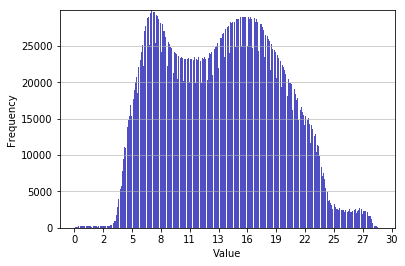

In [33]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=ll, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
def price(x, n):
    ora = x//(60*60)
    return int(ora)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))

ax.xaxis.set_major_formatter(plt.FuncFormatter(price))

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [104]:
max(ll)//(60*60)

29

In [115]:
def col0(n):
    arr = n.split(':')
    return int(arr[0])
ll = list(map(col0, stop_times['arrival_time']))
max(ll)

29

In [116]:
def col0(n):
    arr = n.split(':')
    return int(arr[1])
lll = list(map(col0, stop_times['arrival_time']))
max(lll)

59

In [14]:
(list(routes[routes['route_short_name'].isin(ejszakai)]['route_short_name']))

['6',
 'M2',
 'M4',
 'H8',
 'H8',
 'H9',
 'H6',
 'H6',
 'H6',
 'H5',
 'H5',
 '901',
 '907',
 '908',
 '909',
 '914',
 '914A',
 '916',
 '918',
 '922',
 '923',
 '930',
 '931',
 '934',
 '937',
 '938',
 '940',
 '941',
 '943',
 '948',
 '950',
 '950A',
 '956',
 '963',
 '964',
 '966',
 '968',
 '972',
 '972B',
 '973',
 '979',
 '979A',
 '980',
 '990',
 '992',
 '994',
 '996',
 '996A',
 '998',
 '999',
 'H6',
 '6']

In [15]:
len(ejszakai)

48